# Moving Box - Encoder Decoder Trainer

In [1]:
import sys
sys.path.append('..')
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from util.tf_ops import *
from time import time

from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

/Users/Rishabh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Collect an ensemble of box data

In [75]:
def convert_to_float(collection):
    return [x/255 for x in collection]

def convert_to_uint8(collection):
    return [(x*255).astype(np.uint8) for x in collection]


train_collection = get_collection("../data/data/walking/32x32/train")
#train_collection = augment_reverse_sequence(train_collection)
train_collection = convert_to_float(train_collection)

total_train = sum([x.shape[0] for x in train_collection])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(train_collection), total_train))

person21_walking_d3_uncomp
person22_walking_d2_uncomp
person23_walking_d3_uncomp
person21_walking_d1_uncomp
person23_walking_d4_uncomp
person24_walking_d2_uncomp
person23_walking_d1_uncomp
person21_walking_d4_uncomp
person24_walking_d1_uncomp
person23_walking_d2_uncomp
person21_walking_d2_uncomp
person24_walking_d4_uncomp
person22_walking_d3_uncomp
person22_walking_d4_uncomp
person24_walking_d3_uncomp
person22_walking_d1_uncomp

After Augmentation: img_collections has 16 collections, 11104 images in total


In [76]:
test_collection = get_collection("../data/data/walking/32x32/test")
test_collection = convert_to_float(test_collection)
#test_collection = augment_reverse_color(test_collection)
#test_collection = center_collections(test_collection)
total_test = sum([x.shape[0] for x in test_collection])
print("\nAfter Augmentation: Test set has {} collections, {} images in total".format(len(test_collection), total_test))

person25_walking_d1_uncomp
person25_walking_d4_uncomp
person25_walking_d3_uncomp
person25_walking_d2_uncomp

After Augmentation: Test set has 4 collections, 2484 images in total


## Sample from Collection

In [56]:
def sample(collection, batch_size = 8, gap = 1):
    """
    Input:
        collection: [img_data] - list of ndarray
    Output:
        before_imgs, after_img, mid_imgs -  [batch size, 32, 32]
    """
    assert gap%2==1, "Gap must be odd !"      
    np.random.shuffle(collection)
    # get average number of training for each class
    n_collection = len(collection)
    num_per_collection = [x.shape[0] for x in collection]
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i, imgs in enumerate(collection):
        try:
            s = np.random.choice(range(num_per_collection[i] - gap - 1), avg_num_per_class, replace=False)
            before_ind.append(s)
        except: # if not enough in this class
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+gap+1 for x in before_ind]
    # mid-index for each class
    mid_ind = [x+(gap+1)//2 for x in before_ind]
    
    selected_classes = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([collection[i][before_ind[i]] for i in selected_classes], axis = 0)
    after_imgs = np.concatenate([collection[i][after_ind[i]] for i in selected_classes], axis = 0)
    mid_imgs = np.concatenate([collection[i][mid_ind[i]] for i in selected_classes], axis = 0)
    
    before_imgs = before_imgs[:batch_size]
    mid_imgs = mid_imgs[:batch_size]
    after_imgs = after_imgs[:batch_size]
    return before_imgs, after_imgs, mid_imgs


def sample_train(batch_size = 8, gap = 1): return sample(train_collection, batch_size, gap = gap)

def sample_test(batch_size = 8, gap = 1):  return sample(test_collection, batch_size, gap)

## Take a look at Training data

Range of Image Piece Value: [0.0392156862745098, 0.6705882352941176]
Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


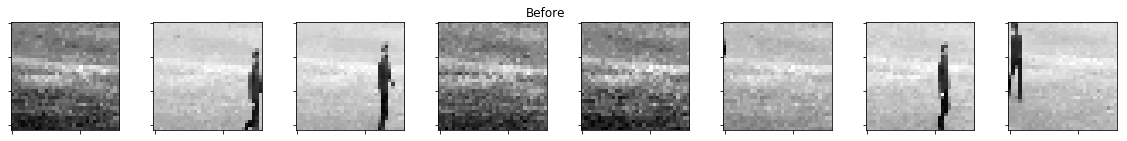

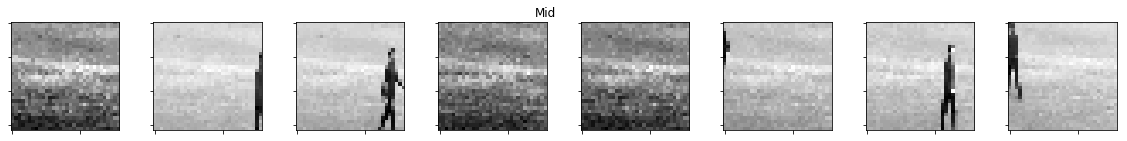

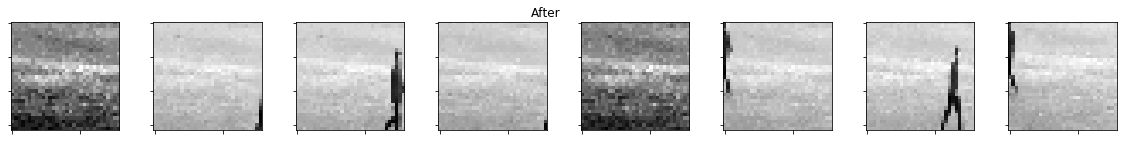

pixel-make sure it is float
0.5058823529411764
0.5176470588235295
0.6705882352941176
0.0392156862745098


In [57]:
def show_sample_train(batch_size, gap):
    before, after, mid = sample_train(batch_size=batch_size, gap=gap)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(mid), np.max(mid)))
    print("Before: {}".format(before.shape))
    print("After:  {}".format(after.shape))
    print("Mid:    {}".format(mid.shape))
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(mid, size, "Mid")
    plot_images(after, size, "After")
    print("pixel-make sure it is float")
    print(mid[4,5,2])
    print(before[3,5,2])
    print(np.max(mid))
    print(np.min(mid))
    
show_sample_train(batch_size = 8, gap = 9)

## Sample of Test Data

Range of Image Piece Value: [0.06274509803921569, 0.8901960784313725]
Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


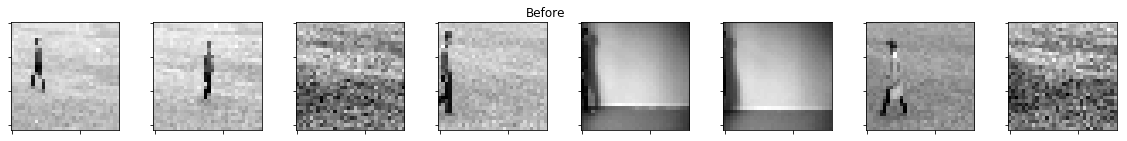

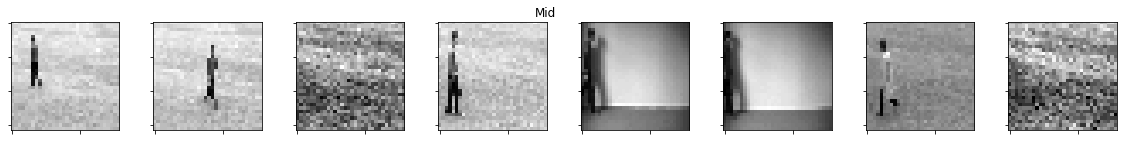

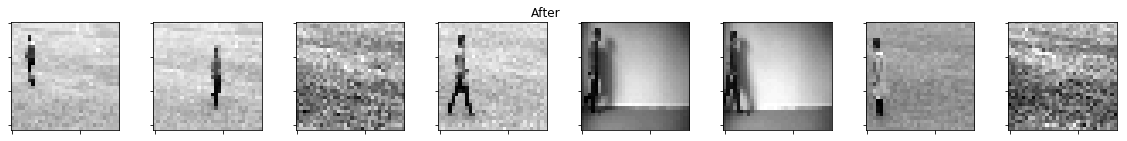

pixel-make sure it is float
0.27450980392156865
0.24705882352941178
0.8901960784313725
0.06274509803921569


In [58]:
def show_sample_test(batch_size, gap):
    before, after, mid = sample_test(batch_size=batch_size, gap=gap)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(mid), np.max(mid)))
    print("Before: {}".format(before.shape))
    print("After:  {}".format(after.shape))
    print("Mid:    {}".format(mid.shape))
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(mid, size, "Mid")
    plot_images(after, size, "After")
    print("pixel-make sure it is float")
    print(mid[4,5,2])
    print(before[3,5,2])
    print(np.max(mid))
    print(np.min(mid))

show_sample_test(batch_size=8, gap = 9)

## Target

### Gap: How harsh do you want to train the model?

In [59]:
gap = 1

### Model Capacity

In [60]:
feature_channel = 256

## Param

In [61]:
batch_size = 32

learning_rate = 5e-4

beta = 0.7 # defalut 0.9 for adam
num_iteration = 1000

model_save_path = "../trained_model/box-32x32-encoder-decorder/{}/".format(time())

## Create Directory for Model to be saved

In [62]:
try:
    os.makedirs(model_save_path)
    print("Model to be saved at {}".format(model_save_path))
except:
    assert "Cannot create save folder!"

Model to be saved at ../trained_model/box-32x32-encoder-decorder/1527711964.235081/


# Encoder

In [63]:
def encode(img, is_training=True):
    """
    Input:
        batch size of img
    Output:
        batch size of feature [batch_size, 8, 8, feature_channel]
    """
    x = tf.reshape(img, [-1, 32, 32, 1])
    x = tf.layers.conv2d(x, filters = 64, kernel_size=5, strides=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = 64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)

    #x = tf.layers.conv2d(x, filters = 128, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)
    #x = tf.layers.conv2d(x, filters = 128, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    x = tf.layers.conv2d(x, filters = feature_channel, kernel_size=2, padding='same', activation=tf.nn.relu)
    
    return x

# Decoder

In [64]:
def decode(feature, is_training=True):
    """
    Input:
        batch size of feature [batch_size, 8, 8, feature_channel]
    Output:
        batch size of img [batch_size, 32, 32, 1]
    """
    x = feature
    x = tf.layers.conv2d(x, filters = 128, kernel_size=5, padding='same', activation=tf.nn.relu)
    x = tf.layers.conv2d_transpose(x, filters=128, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')
    #x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=3,  strides=2, activation=tf.nn.tanh, padding='same')
    #x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=2,  strides=1, activation=tf.nn.tanh, padding='same')
    img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=2,  strides=2, activation=tf.nn.tanh, padding='same')
    return img

## Generator

### Loss

In [65]:
def content_loss(x, gd):
    x, gd = tf.contrib.layers.flatten(x), tf.contrib.layers.flatten(gd)
    return tf.norm(x-gd)

### Get a Batch Generation

In [66]:
def get_generattion(before, after, mid):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    feature_before, feature_after = sess.run([encoder_output_before, \
            encoder_output_after], dic)
    ave_feature = ((feature_before.astype(int) + feature_after.astype(int))/2).astype(np.uint8)
    gen_batch = sess.run(G_batch, feed_dict={decoder_input:ave_feature})
    return gen_batch

### Solver

In [67]:
def get_solver(learning_rate=1e-3, beta1=0.5):
    return tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

### Report Loss = loss_computed * 255 / batch_size

In [68]:
def report_loss(name, num_run = 100, gap = 3, batch_size = batch_size,):
    losses = []
    for _ in range(num_run):
        if name == "train": before, after, mid = sample_train(batch_size, gap)
        elif name == "val": before, after, mid = sample_dev(batch_size, gap)
        else:                before, after, mid = sample_test(batch_size, gap) 
        feature_before, feature_after = sess.run([encoder_output_before, \
                                                  encoder_output_after], feed_dict={batch_before: before, batch_after: after})
        ave_feature =  ((feature_before.astype(int) + feature_after.astype(int))/2).astype(np.uint8)
        
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={decoder_input: ave_feature, batch_mid: mid})
        loss = scale_loss(G_loss_curr/batch_size, 2)# tweek loss to match report loss
        losses.append(loss)
    return scale_loss(np.mean(losses) / batch_size, 2)

## Computational Graph

In [69]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32], "batch_mid")
batch_before     = tf.placeholder(tf.float32, [None, 32, 32], "batch_before")
batch_after      = tf.placeholder(tf.float32, [None, 32, 32], "batch_after")

decoder_input   = tf.placeholder(tf.float32, [None, 8, 8, feature_channel], "decoder_input")
is_training      = tf.placeholder(tf.bool, (), name = "is_training")

with tf.variable_scope("generator") as scope:
    encoder_output_before = encode(batch_before)
    encoder_output_after = encode(batch_after)
    G_batch = decode(decoder_input)
    
G_loss = content_loss(G_batch, batch_mid)
G_solver = get_solver(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
# add to saver
tf.add_to_collection('decoder', G_batch)
tf.add_to_collection('encoder', encoder_output_before)

In [70]:
def train(sess, G_step, G_loss, batch_size, num_iteration, plot_every = 400, show_loss_every=400, nPlot=6, num_plot = 6):
    g_losses = []
    saver = tf.train.Saver()
    for i in range(num_iteration):
        # get a sample
        gap = 1 #np.random.choice([1,3,5])
        real_before, real_after, real_mid = sample_train(batch_size, gap)
#         dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        feature_before, feature_after = sess.run([encoder_output_before, \
                                                  encoder_output_after], {batch_before: real_before, batch_after: real_after})
        ave_feature = ((feature_before.astype(float) + feature_after.astype(float))/2)
        
        _, G_loss_curr = sess.run([G_train_step, G_loss], {decoder_input: ave_feature, batch_mid: real_mid})
        G_loss_curr = scale_loss(G_loss_curr/batch_size, 2)# tweek loss to match report loss
        
        g_losses.append(G_loss_curr)
    
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {} | Gap = {}".format(i, G_loss_curr, gap))
            
        if i%plot_every == 0:
            real_before, real_after, real_mid = sample_train(num_plot, gap)
            feature_before, feature_after = sess.run([encoder_output_before, \
                                                  encoder_output_after], {batch_before: real_before, batch_after: real_after})
            gen_batch_test = sess.run(G_batch, feed_dict=\
                                      {decoder_input: ave_feature, batch_mid: real_mid, is_training: False})
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {} | gap = {}".format(i + plot_every, gap))
    saver.save(sess, model_save_path, global_step = i)       
    return g_losses

# Train !

Iteration 0:  G_loss = 376.12208783626556 | Gap = 1


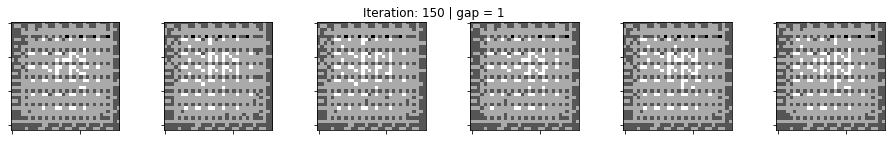

Iteration 100:  G_loss = 47.11972117424011 | Gap = 1


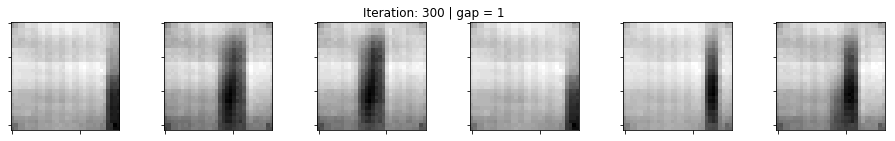

Iteration 200:  G_loss = 36.51385948061943 | Gap = 1
Iteration 300:  G_loss = 33.30715835094452 | Gap = 1


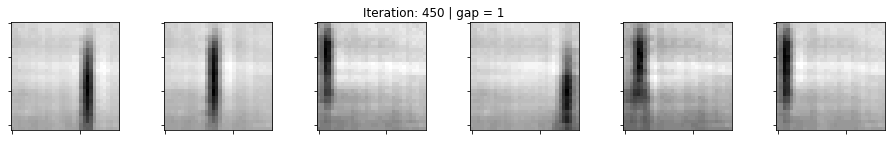

Iteration 400:  G_loss = 33.37161049246788 | Gap = 1


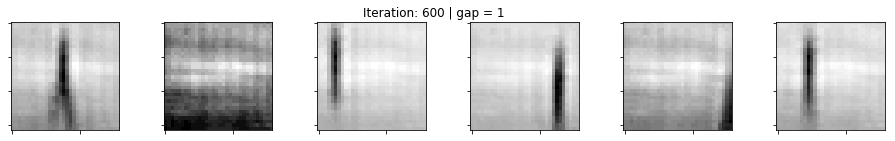

Iteration 500:  G_loss = 31.35961465537548 | Gap = 1
Iteration 600:  G_loss = 33.807576298713684 | Gap = 1


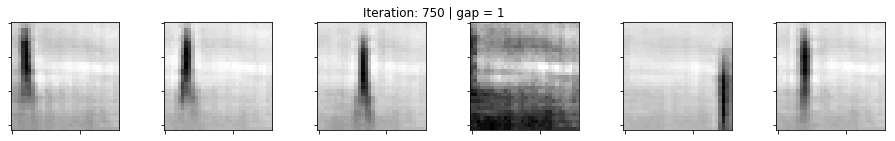

Iteration 700:  G_loss = 29.76838544011116 | Gap = 1


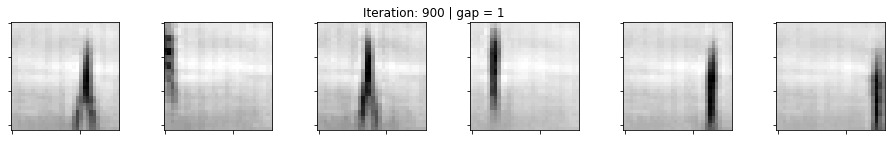

Iteration 800:  G_loss = 29.078110679984093 | Gap = 1
Iteration 900:  G_loss = 28.424226567149162 | Gap = 1


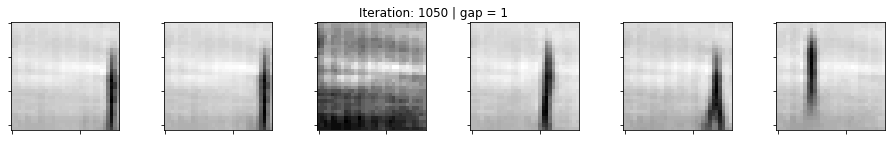

In [71]:

sess = get_session()

#if (load_checkpoint==True):
#    new_saver = tf.train.import_meta_graph('../trained_model/box-32x32-encoder-decorder/first/-299.meta')
#    new_saver.restore(sess, tf.train.latest_checkpoint('../trained_model/box-32x32-encoder-decorder/first/'))

sess.run(tf.global_variables_initializer())

g_loss = train(sess, G_train_step, G_loss, batch_size, num_iteration, plot_every = 150, show_loss_every = 100, num_plot=6)

## Plot Learning Curve

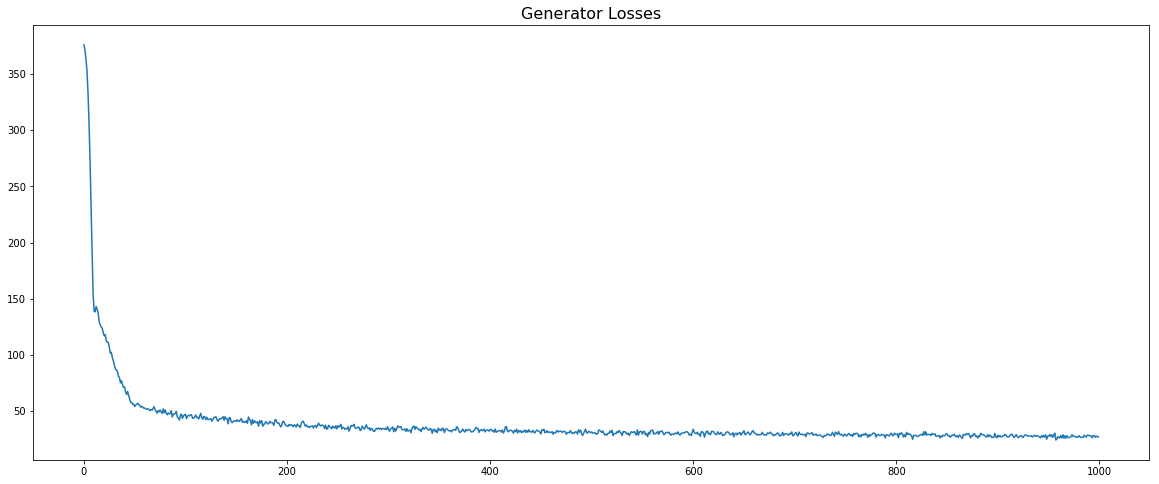

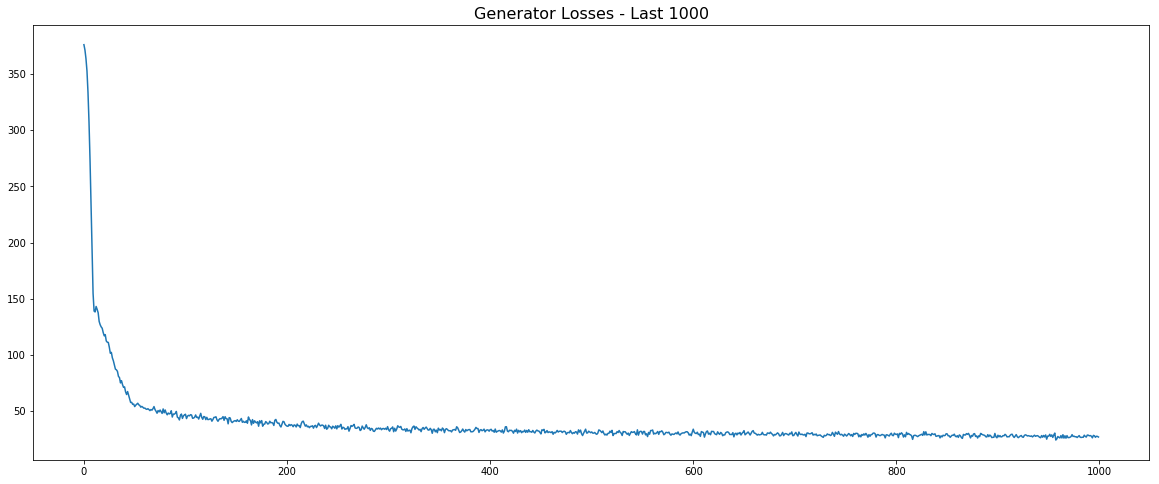

In [72]:
figsize = (20, 8)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses", fontsize=16)
plt.show()

plt.figure(figsize=figsize)
plt.plot(g_loss[-1000:])
plt.title("Generator Losses - Last 1000", fontsize=16)
plt.show()

# Evaluate !

In [73]:
def show_generations(name, num = 6, gap = 3):
    if name == "train":  before, after, mid = sample_train(num, gap)
    else:                before, after, mid = sample_test(num, gap) 
    
    gen_batch = get_generattion(before, after, mid)
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    plot_images(mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")
    plot_images(((after+mid)/2), size, "Mid - Interpolated")
    

## - Evaluate on Training Data

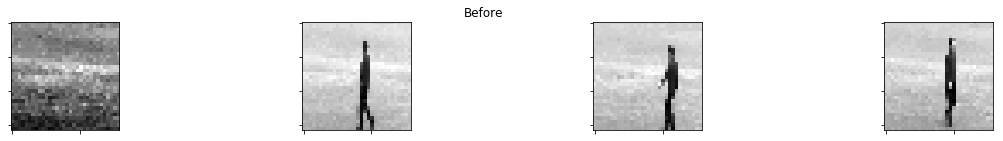

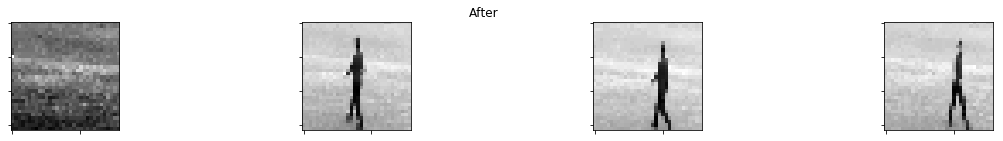

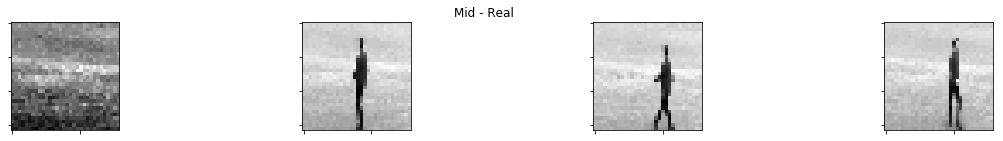

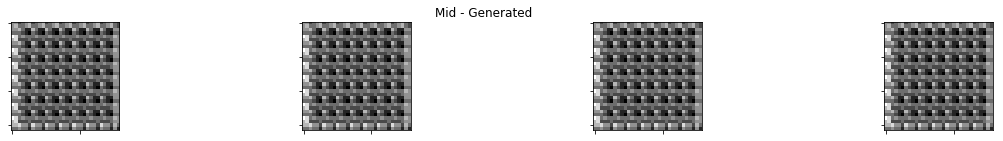

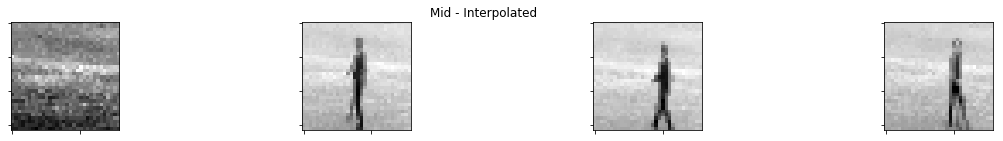

Training Loss = 279.28363529371563


In [74]:
def eval_train(num_show = 8, gap = 3):
    show_generations("train", num_show, gap)
    loss = report_loss("train", 100, gap, batch_size)
    print("Training Loss = {}".format(loss))
    return loss

train_loss = eval_train(num_show = 4, gap = 7)

## - Evaluate on Test Data

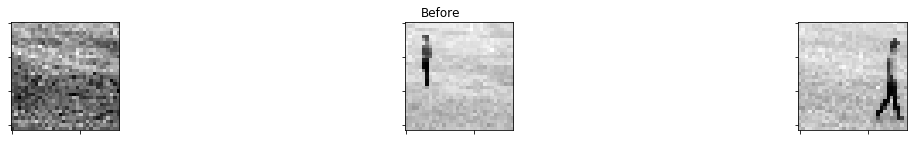

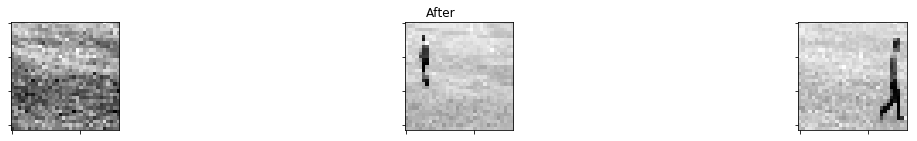

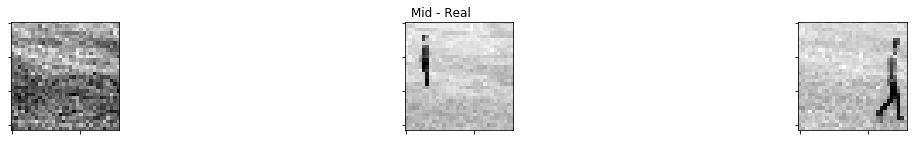

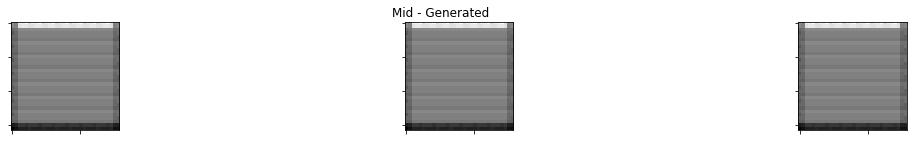

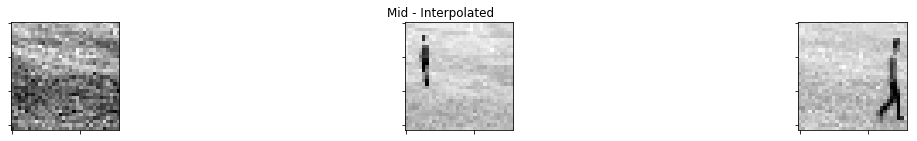

Test Loss = 2203.7103165448643


In [31]:
def eval_test(num_show = 6, gap = 3, num_test = 100, batch_size = batch_size):
    show_generations("test", num_show, gap)
    loss = report_loss("test", num_test, gap, batch_size)
    print("Test Loss = {}".format(loss))
    return loss

test_loss = eval_test(num_show = 3, gap=1, batch_size = 8)

## How much overfitting?

In [98]:
print("(Test Loss - Train Loss)/Train Loss = {}".format((test_loss-train_loss)/train_loss))

(Test Loss - Train Loss)/Train Loss = 63.01719978318376
